In [1]:
source('../functions.R')
tcelle = readRDS('Data/tcell_e.RDS')
tcelld = readRDS('Data/tcell_d.RDS')
tcr =readRDS('Data/tcrCDR3.RDS')
setwd('Figures/Figure 5')

Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.5.3"Loading required package: cowplot
Warning message:
"package 'cowplot' was built under R version 3.5.3"
********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: Matrix
Warning message:
"package 'feather' was built under R version 3.5.3"Warning message:
"package 'dplyr' was built under R version 3.5.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: viridisLite
Warning message:
"package 'tidyr' was built under R version 3.5.3"
Attaching package: 'tidyr'

The following object

In [2]:
tcelle@meta.data$TRB_CDR3 = tcr@meta.data[tcelle@cell.names, 'TRB_CDR3']
tcelle@meta.data$TRA_CDR3 = tcr@meta.data[tcelle@cell.names, 'TRA_CDR3']
tcelld@meta.data$TRB_CDR3 = tcr@meta.data[tcelld@cell.names, 'TRB_CDR3']
tcelld@meta.data$TRA_CDR3 = tcr@meta.data[tcelld@cell.names, 'TRA_CDR3']

In [3]:
# calculate clonal sizes (blocked by patient)

tcelld@meta.data$trb_size = NA
for (pat in unique(tcelld@meta.data$patient)) {
    ind = which(tcelld@meta.data$patient == pat & !is.na(tcelld@meta.data$TRB_CDR3))
    tab = table(tcelld@meta.data$TRB_CDR3[ind])
    tcelld@meta.data[ind, 'trb_size'] = tab[tcelld@meta.data[ind, 'TRB_CDR3']]
}
table(tcelld@meta.data$trb_size)


tcelle@meta.data$trb_size = NA
for (pat in unique(tcelle@meta.data$patient)) {
    ind = which(tcelle@meta.data$patient == pat & !is.na(tcelle@meta.data$TRB_CDR3))
    tab = table(tcelle@meta.data$TRB_CDR3[ind])
    tcelle@meta.data[ind, 'trb_size'] = tab[tcelle@meta.data[ind, 'TRB_CDR3']]
}
table(tcelle@meta.data$trb_size)



  1   2   3   4   5   6   8  12  16  17  18  24  48 
992 112  51  32  30  30   8  12  16  34  36  24  48 


  1   2   3   4   5   7   8   9  10  11  21  25  32  36  74 
952 214 117  92  40  28  16  18  20  11  21  25  32  36  74 

In [4]:
tcr_both = MergeSeurat(tcelle, tcelld)

tcr_both@meta.data$pheno = NA
tcr_both@meta.data$pheno[tcr_both@meta.data$plot_cluster %in% c('E1', 'E2', 'D2')] = 'Trm'
tcr_both@meta.data$pheno[tcr_both@meta.data$plot_cluster %in% c('E5', 'D1')] = 'Th17'
tcr_both@meta.data$pheno[tcr_both@meta.data$plot_cluster %in% c('E3', 'D5')] = 'Treg'
tcr_both@meta.data$pheno[tcr_both@meta.data$plot_cluster %in% c('E6')] = 'peTh2'

tcr_both@meta.data$plot_pheno = tcr_both@meta.data$pheno

table(tcr_both@meta.data$plot_pheno)



peTh2  Th17  Treg   Trm 
  236  2138   592  4557 

In [5]:
tcelle@meta.data$plot_pheno = tcr_both@meta.data[tcelle@cell.names, 'plot_pheno']
tcelld@meta.data$plot_pheno = tcr_both@meta.data[tcelld@cell.names, 'plot_pheno']

tcelle@meta.data$plot_pheno[tcelle@meta.data$plot_cluster == 'E4'] = 'NK'
tcelld@meta.data$plot_pheno[tcelld@meta.data$plot_cluster %in% c('D3', 'D4', 'D6')] = 'NK'

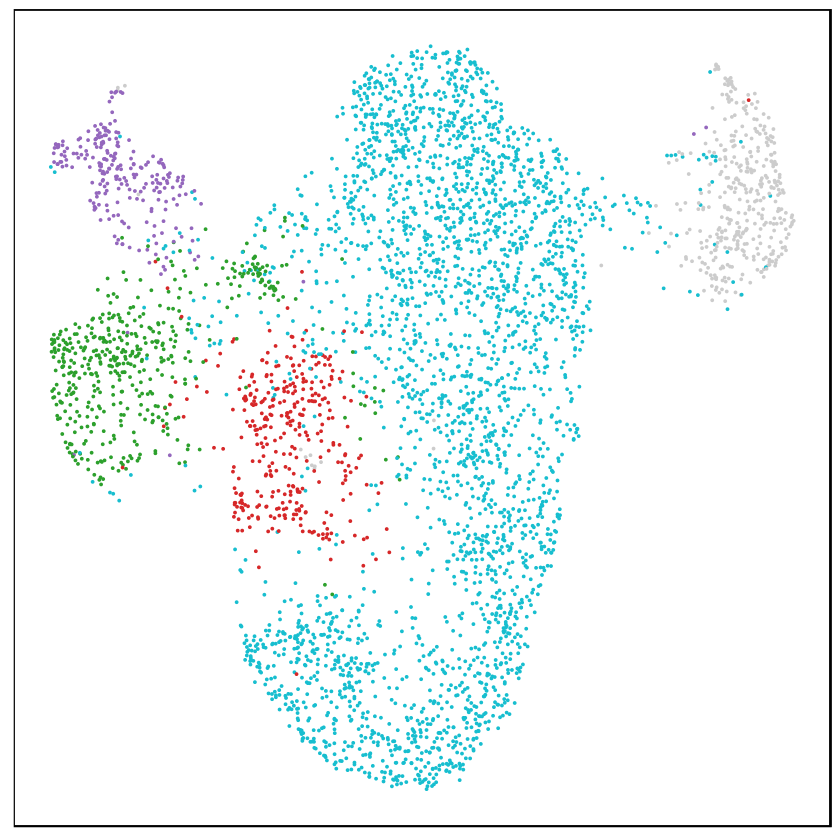

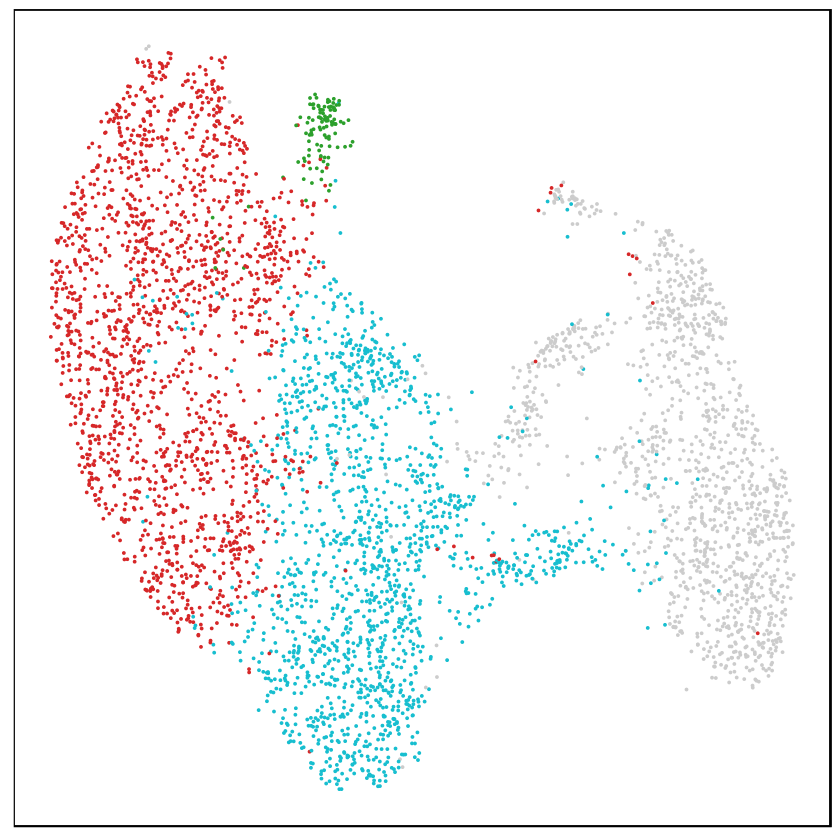

In [6]:
palettes <- c(ggthemes_data[["tableau"]][["color-palettes"]]$regular$`Classic 10`$value[c(6,7,8,1)], 'grey80')
names(palettes) = c('peTh2', 'Th17', 'Treg', 'Trm', 'NK')
tcelle = addUMAP(tcelle)
ggplot(shuffle(tcelle@meta.data), aes(x = UMAP1,  y = UMAP2, color = plot_pheno)) + geom_point(size = .01) + scale_color_manual(values = palettes) + UMAP_theme
ggsave('eso_pheno.pdf', height = 1.6, width = 1.6, useDingbats = FALSE)
tcelld = addUMAP(tcelld)
ggplot(shuffle(tcelld@meta.data), aes(x = UMAP1,  y = UMAP2, color = plot_pheno)) + geom_point(size = .01) + scale_color_manual(values = palettes) + UMAP_theme
ggsave('duo_pheno.pdf', height = 1.6, width = 1.6, useDingbats = FALSE)


Warning message:
"Removed 2727 rows containing missing values (geom_point)."

Warning message:
"Removed 2727 rows containing missing values (geom_point)."Warning message:
"Removed 2727 rows containing missing values (geom_point)."

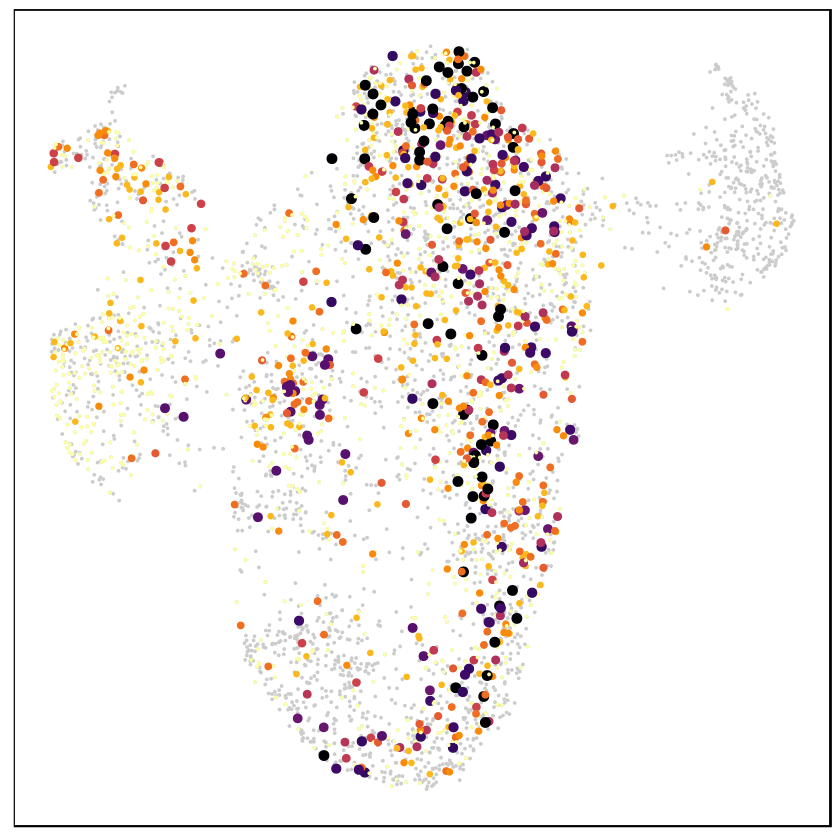

Warning message:
"Removed 2727 rows containing missing values (geom_point)."

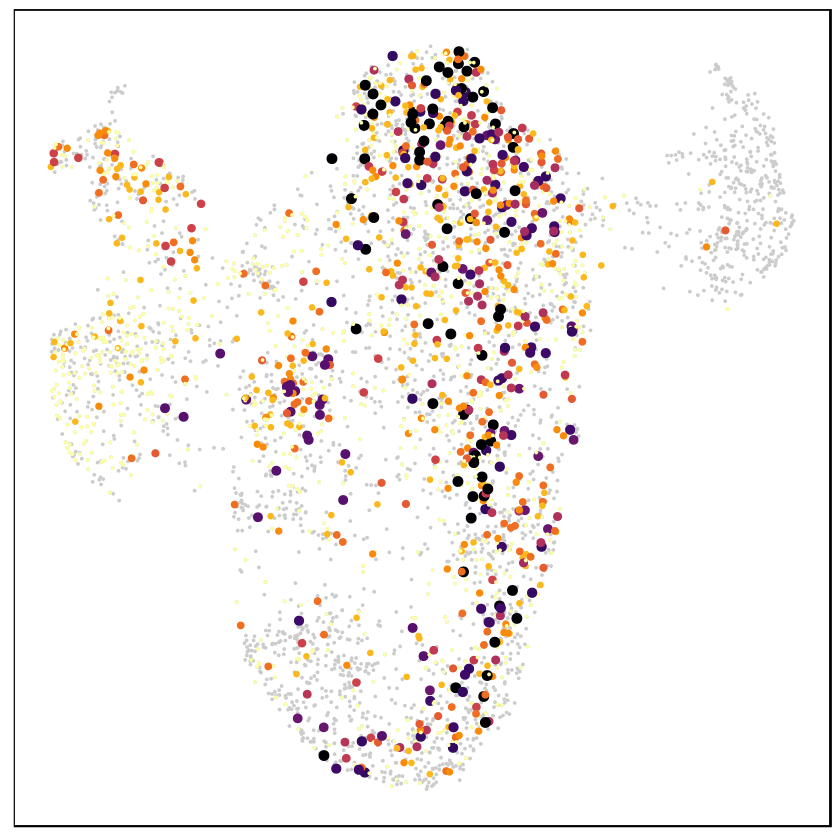

In [7]:
tcelle = addUMAP(tcelle)
ggplot(tcelle@meta.data) + geom_point(aes(x = UMAP1, y = UMAP2), color = 'grey80', size = .01) + 
geom_point(data = tcelle@meta.data %>% filter(plot_cluster != 'NK'), aes(x = UMAP1, y = UMAP2, size = log2(trb_size), color = log2(trb_size)))  + 
scale_color_viridis(breaks = c(0, 2, 4, 6, 8), direction = -1, option = 'B') +
UMAP_theme + 
scale_size_continuous(range = c(.01, 2), breaks = c(0,2, 4, 6, 8)) + guides(fill = FALSE, size = FALSE)
ggsave('eso_expand.pdf', height =1.6, width = 1.6, useDingbats = FALSE)

ggplot(tcelle@meta.data) + geom_point(aes(x = UMAP1, y = UMAP2), color = 'grey80', size = .01) + geom_point(aes(x = UMAP1, y = UMAP2, size = log2(trb_size), color = log2(trb_size)))  +
scale_color_viridis(breaks = c(0, 2, 4, 6, 8), direction = -1, option = 'B') +
UMAP_theme + 
scale_size_continuous(range = c(.01, 2), breaks = c(0,2, 4, 6, 8)) + guides(fill = FALSE, size = FALSE)
ggsave('eso_expand_legend.pdf', height = 4, width = 1.6, useDingbats = FALSE)

Warning message:
"Removed 3356 rows containing missing values (geom_point)."

Warning message:
"Removed 3356 rows containing missing values (geom_point)."Warning message:
"Removed 3356 rows containing missing values (geom_point)."

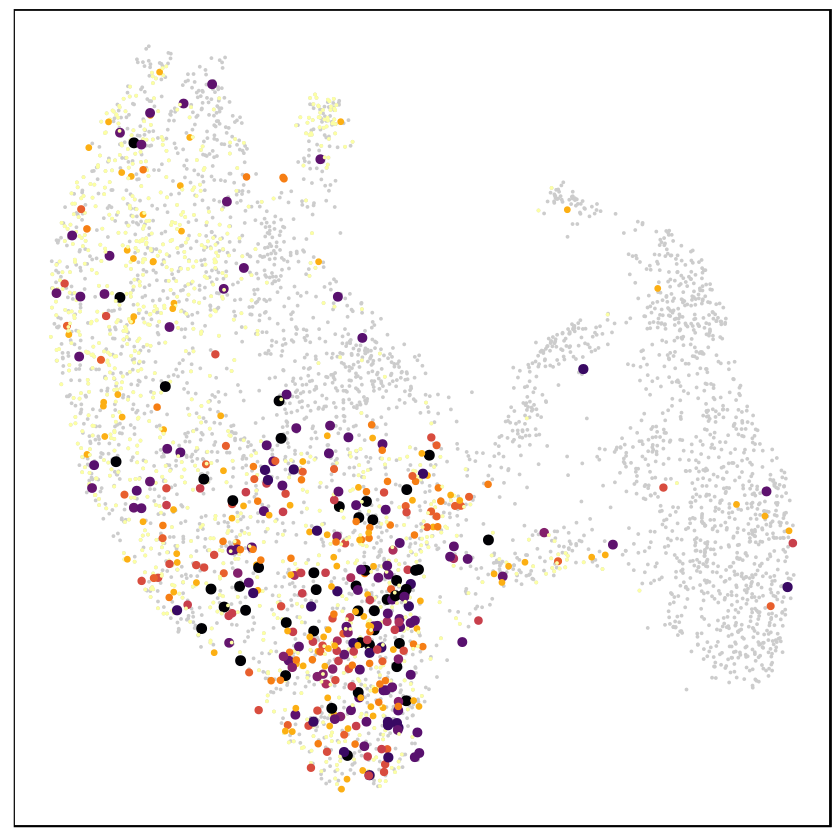

Warning message:
"Removed 3356 rows containing missing values (geom_point)."

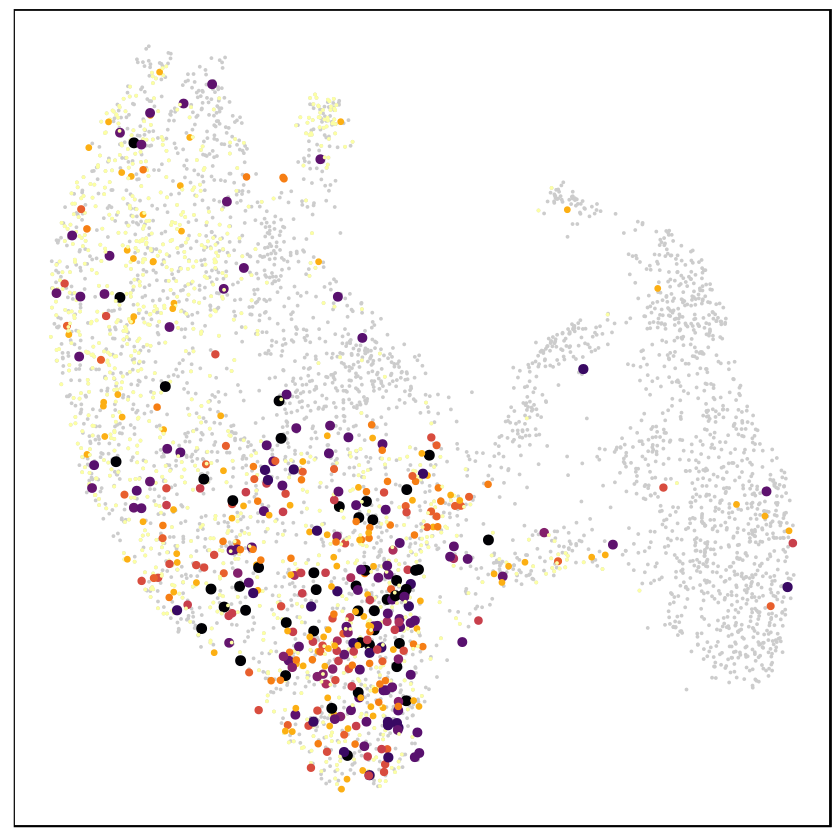

In [8]:
tcelld = addUMAP(tcelld)
ggplot(tcelld@meta.data) + geom_point(aes(x = UMAP1, y = UMAP2), color = 'grey80', size = .01) + geom_point(aes(x = UMAP1, y = UMAP2, size = log2(trb_size), color = log2(trb_size)))  + 
scale_color_viridis(breaks = c(0, 2, 4, 6, 8), direction = -1, option = 'B') +
UMAP_theme + 
scale_size_continuous(range = c(.01, 2), breaks = c(0,2, 4, 6, 8)) + guides(fill = FALSE, size = FALSE)
ggsave('duo_expand.pdf', height = 1.6, width =1.6, useDingbats = FALSE)

ggplot(tcelld@meta.data) + geom_point(aes(x = UMAP1, y = UMAP2), color = 'grey80', size = .01) + geom_point(aes(x = UMAP1, y = UMAP2, size = log2(trb_size), color = log2(trb_size)))  + 
scale_color_viridis(breaks = c(0, 2, 4, 6, 8), direction = -1, option = 'B') +
UMAP_theme + 
scale_size_continuous(range = c(.01, 2), breaks = c(0,2, 4, 6, 8))
ggsave('duo_expand_legend.pdf', height = 1.6, width = 4, useDingbats = FALSE)

In [9]:
tcr@meta.data$plot_cluster = NA
tcr@meta.data[tcelle@cell.names, 'plot_cluster'] = tcelle@meta.data$plot_cluster
tcr@meta.data[tcelld@cell.names, 'plot_cluster'] = tcelld@meta.data$plot_cluster

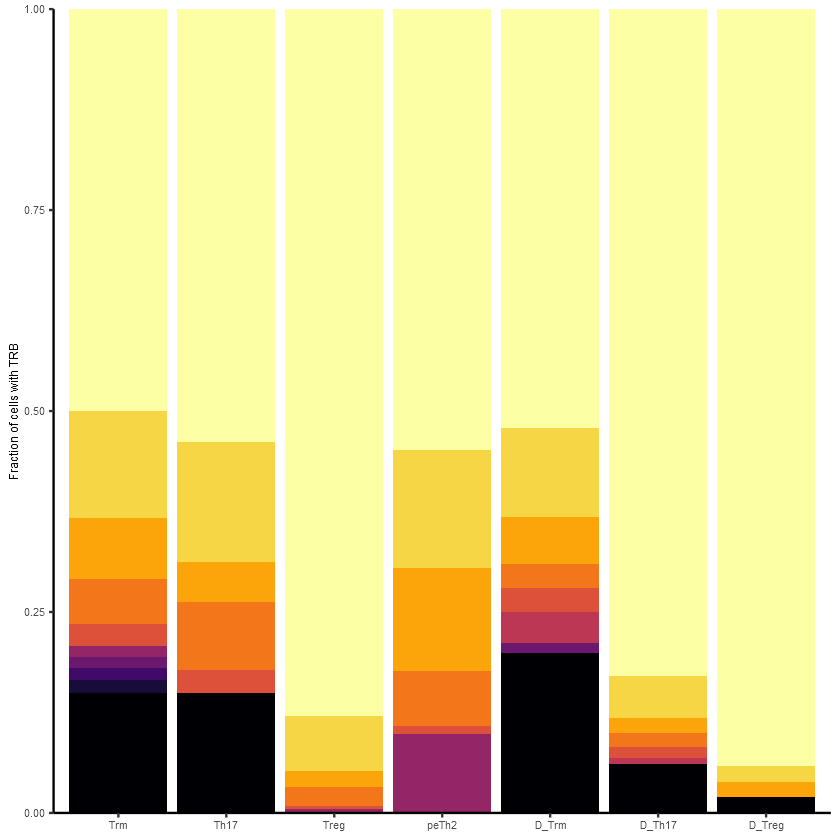

In [10]:
tcr@meta.data$trb_size = NA
tcr@meta.data[tcelle@cell.names, 'trb_size'] = tcelle@meta.data$trb_size
tcr@meta.data[tcelld@cell.names, 'trb_size'] = tcelld@meta.data$trb_size

tcr@meta.data$trb_size = as.character(tcr@meta.data$trb_size)
tcr@meta.data$trb_size[as.numeric(tcr@meta.data$trb_size) > 10] = '>10'
tcr@meta.data$trb_size = factor(tcr@meta.data$trb_size, levels = c(1,2,3,4,5,6,7,8,9, 10, '>10'))

ggplot(tcr@meta.data %>% filter(!is.na(trb_size), !is.na(pheno)), aes(x = pheno, fill = factor(trb_size))) + geom_bar(position = 'fill') +
scale_x_discrete(limits = c('Trm', 'Th17', 'Treg', 'peTh2', 'D_Trm', 'D_Th17', 'D_Treg'))+
scale_fill_viridis_d(option = 'inferno', direction = -1) + theme_classic() + Axis_themes + guides(fill = FALSE) + labs(x = c(), y = 'Fraction of cells with TRB') + 
scale_y_continuous(expand = c(0,0)) + theme(axis.title.y = element_text(size = 7))

ggsave('tcr_expanded_count.pdf', height = 1.66, width = 1.35, useDingbats = FALSE)


In [11]:
# define clonotypes of peTh2 cells
sub = tcelle@meta.data %>% filter(pheno == 'peTh2')
expanded = c(sub$TRB_CDR3[duplicated(sub$TRB_CDR3)], sub$TRA_CDR3[duplicated(sub$TRA_CDR3)])
expanded = unique(expanded)
expanded = expanded[!is.na(expanded)]

sub$clone_size = NA
tra_pairs = c()
i = 1
n = c()
sub$TRB_CDR3 = as.character(sub$TRB_CDR3)
sub$TRA_CDR3 = as.character(sub$TRA_CDR3)
for (trbclone in expanded[1:17]) {
    tra = sub$TRA_CDR3[sub$TRB_CDR3 == trbclone]
    tra = tra[!is.na(tra)]
    tab = table(tra)
    tab = tab[order(tab, decreasing = TRUE)]
    if (length(tra) > 0) {
        tra_pairs[i] = names(tab)[1]
    }
    else {
        tra_pairs[i] = 'NA'
    }
    i= i+1
}

trb_pairs = c()
i = 1
for (traclone in expanded[17:28]) {
    tra = sub$TRB_CDR3[sub$TRA_CDR3 == traclone]
    tra = tra[!is.na(tra)]
    tab = table(tra)
    tab = tab[order(tab, decreasing = TRUE)]
    if (length(tra) > 0) {
        trb_pairs[i] = names(tab)[1]
    }
    else {
        trb_pairs[i] = 'NA'
    }
    i= i+1
}

clone_frame = data.frame(trb = c(expanded[1:17], trb_pairs), tra = c(tra_pairs, expanded[17:28]))
clone_frame = clone_frame[!duplicated(clone_frame$trb),]

5
3
7
2
4
2
3
3
3
2
3
4
0
0
0
0
0
3
2
0


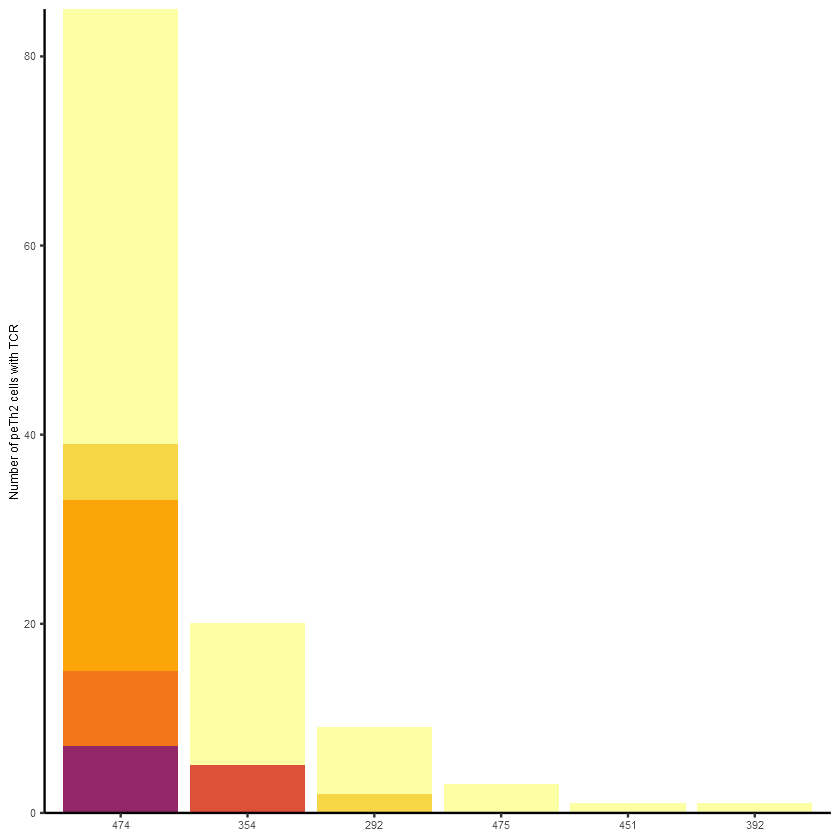

In [12]:
sizepal = rev(inferno(11))
names(sizepal) = c(1,2,3,4,5,6,7,8,9, 10, '>10')
sub$clone_size = NA
sub$clone_size[!is.na(sub$TRB_CDR3) | !is.na(sub$TRA_CDR3)] = 1
for (row in 1:dim(clone_frame)[1]) {
    cells = which(sub$TRB_CDR3 == clone_frame$trb[row] | sub$TRA_CDR3 == clone_frame$tra[row])
    n = length(cells)
    message(n)
    sub[cells, 'clone_size'] = n
}


# removing cells without TCR and patient with peTh2 cell that is in remission
ggplot(sub %>% filter(!is.na(clone_size), patient != 471), aes(x = factor(patient, levels = c(474, 354, 292, 475, 451, 392)), fill = factor(clone_size, levels = c(1,2,3,4,5,6,7,8)))) + geom_bar() + 
scale_fill_manual(values = sizepal) + theme_classic() +  Axis_themes + 
labs(x = 'Patient', y = 'Number of peTh2 cells with TCR') + theme(panel.border = element_blank(), axis.line = element_line(color = 'black'), axis.title = element_text(size = 7), 
      axis.text.x = element_text(size = 6, angle = 0), axis.text.y = element_text(size = 6), axis.title.y = element_text(size = 7)) + labs(fill = 'Clonal size') + guides(fill = FALSE) + scale_y_continuous(expand =c(0,0)) + 
Axis_themes + labs(x = c())
ggsave('patient_expansion.pdf', height = 1.66, width = 1.35)

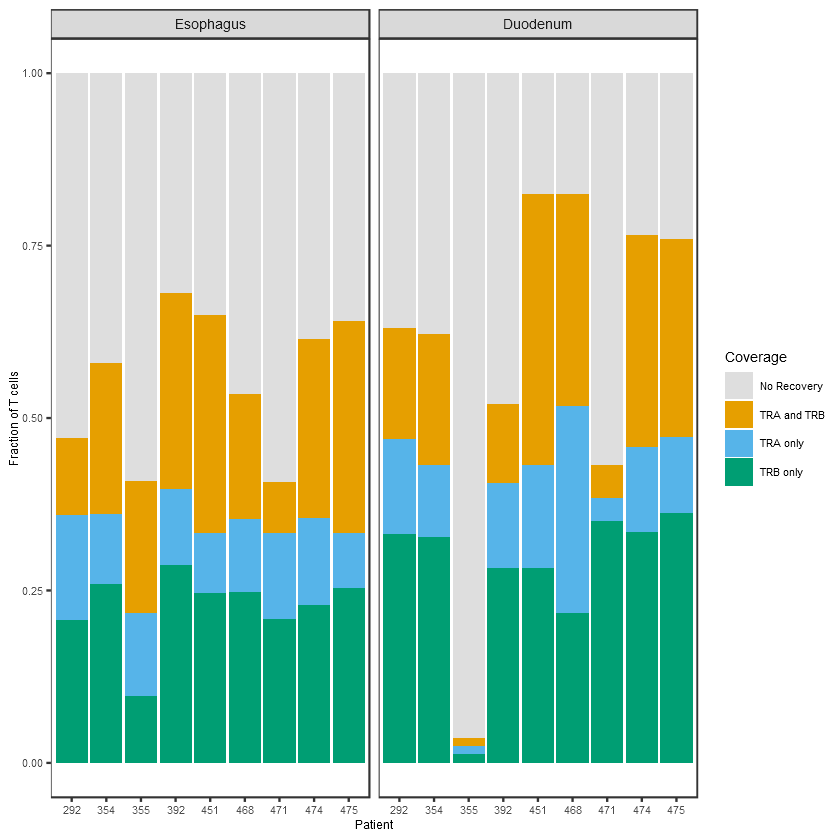

In [13]:
cbPalette <- c("gray87", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

tcr@meta.data$tissue = factor(as.character(tcr@meta.data$tissue), levels = c("Esophagus", 'Duodenum'))
ggplot(tcr@meta.data %>% filter(patient != 249, !pheno %in% c('NK', 'D_Ki-67+')), aes(x = factor(patient), fill = TCR_Recovery)) + geom_bar(position = 'fill') +
facet_wrap(~tissue)+scale_fill_manual("Coverage", values = c("TRA only" = cbPalette[3], "TRB only" = cbPalette[4], "TRA and TRB" = cbPalette[2], 'No Recovery' = cbPalette[1])) + remove_grid + Axis_themes +
labs(x = 'Patient', y = 'Fraction of T cells') + theme(axis.title = element_text(size = 7))
ggsave('TCRrecovery.pdf', height = 3, width = 5, useDingbats = FALSE)

In [14]:
table(tcr@meta.data$TCR_Recovery[tcr@meta.data$patient != 249])

(1402)/6518
(1402+1878)/6518
(1402+722)/6518


No Recovery TRA and TRB    TRA only    TRB only 
       2562        1426         842        1688 

[1] 0.2150967

[1] 0.5032218

[1] 0.3258668